#### Initialize Functions

In [5]:
from textblob import TextBlob
import json
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')
import os
from random import randint
import numpy as np
import pandas as pd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def getBarGraph(x,y):
  plt.bar(x, y, color=['green', 'red'])
  plt.xlabel('Emotion')
  plt.ylabel('Count')
  plt.title(f'Total Count of Satisfaction and Unsatisfied Occurrences ({sum(y)})')
  plt.show()

In [7]:
#gpt threshold is the threshold for cutting of polarity of gpt between satisfied or not
#user threshold is the threshold for user prompts, satisfied or not
def getSentimentAnalysis(fsObject,gptThreshold,userThreshold):
  reactions = []
  avgs = defaultdict(list)
  languages = defaultdict(list)
  percent = 8
  for i in fsObject:
    totalConversations = len(i['Conversations'])-1
    fromIndex = totalConversations-round(percent * totalConversations / 100.0)
    answerPolarity = []
    promptPolarity = []
    for x in i['Conversations']:
      userPolarity = TextBlob(x['Prompt']).sentiment.polarity
      gptPolarity = TextBlob(x['Answer']).sentiment.polarity
      promptPolarity.append(userPolarity)
      answerPolarity.append(gptPolarity)

    #Checking if ChatGPT able to solve the problem by observing all the answers given
    # posOrNeg = 1 if min(answerPolarity) >= gptThreshold else -1



    # posOrNeg = 1 if min(answerPolarity[fromIndex:]) >= gptThreshold else -1

    n = len(answerPolarity)
    posOrNeg=1
    if n>2:
      start , bucket = n,n
      fInd = int(n*0.8)
      for y in range(fInd):
        bucket+=answerPolarity[y]
      avg = [(x+1)*answerPolarity[x] for x in range(fInd,n)]
      cal = sum(avg)/len(avg)

      bucket+=cal
      posOrNeg = 1 if start>bucket else -1
      # print(bucket,start,posOrNeg)



    lengthOfConversation = len(i['Conversations'])
    for index in range(lengthOfConversation):
      languagePolarity = 0
      if index+1<lengthOfConversation:

        if promptPolarity[index+1]<0:
          languagePolarity = -1
        elif promptPolarity[index+1]>0:
          languagePolarity = 1

        # languagePolarity = 1 if promptPolarity[index+1]>userThreshold else -1
      else:
        languagePolarity = 1


      for code in i['Conversations'][index]['ListOfCode']:
        if code['Type']:
          codeType = code['Type'].lower()
          if codeType in ['csharp','c#','C#']:
            codeType = 'c#'
          languages[codeType].append(languagePolarity)
          if posOrNeg == -1:
            avgs[codeType].append(i['NumberOfPrompts'])
    reactions.append(posOrNeg)
  return reactions,languages,avgs

In [8]:
def readJSONObj(jsonFilePath):
  with open(jsonFilePath, 'rb') as file:
      fsObject = json.load(file)
  return fsObject

In [9]:
def initializeJSON():
  objArray = []
  dirAddress = '/content/drive/My Drive/Masters/SE'
  files = os.listdir(dirAddress)
  for filename in files:
    file_path = os.path.join(dirAddress, filename)
    jsonObj = readJSONObj(file_path)
    objArray.append(jsonObj)
  return objArray

In [10]:
def getSatisfactionGraph(totalFSReactions):
  labels = ['Happy','Sad']
  hCount,sCount = 0,0
  for i in totalFSReactions:
    if i==1:
      hCount+=1
    else:
      sCount+=1
  print(f'Satisfied Count: {hCount} and Unsatisfied count: {sCount}')
  counts = [hCount,sCount]
  getBarGraph(labels,counts)

In [11]:
def getSatisfactionGraphByLanguageWithBias(totalFSLang,totalFSReactions):
  categories = ['Happy','Sad']
  index = range(len(totalFSLang))

  totalLanguages = totalFSLang.keys()
  neutralCounts = [totalFSLang[x].count(0)//2 for x in totalFSLang]
  sadCounts = [totalFSLang[x].count(-1) +y for x,y in zip(totalFSLang,neutralCounts)]
  happyCounts = [totalFSLang[x].count(1) +y for x,y in zip(totalFSLang,neutralCounts)]

  bar_width = 0.35
  fig, ax = plt.subplots(figsize=(20, 6))
  bar1 = ax.bar(index, happyCounts, bar_width, label='Happy')
  bar2 = ax.bar([i + bar_width for i in index], sadCounts, bar_width, label='Sad')

  ax.set_xlabel('Languages')
  ax.set_ylabel('Conversations')
  ax.set_title('Satisfactory level by Language')

  ax.set_xticks([i + bar_width/2 for i in index]) # for 2 bars
  ax.set_xticklabels(totalLanguages,rotation=90)
  ax.legend()

  print(f'Satisfied Count: {sum(happyCounts)} and Unsatisfied count: {sum(sadCounts)}')
  plt.show()

# getSatisfactionGraphByLanguage(totalFSLang,totalFSReactions)

In [12]:
def getSatisfactionGraphByLanguageWithNeutral(totalFSLang,totalFSReactions):
  categories = ['Happy','Sad']
  index = range(len(totalFSLang))

  totalLanguages = totalFSLang.keys()
  happyCounts = [totalFSLang[x].count(1) for x in totalFSLang]
  neutralCounts = [totalFSLang[x].count(0) for x in totalFSLang]
  sadCounts = [totalFSLang[x].count(-1) for x in totalFSLang]

  bar_width = 0.2
  fig, ax = plt.subplots(figsize=(20, 6))
  # bar1 = ax.bar(index, happyCounts, bar_width, label='Happy')
  # bar2 = ax.bar([i + bar_width for i in index], sadCounts, bar_width, label='Sad')
  # bar3 = ax.bar([i + 2 *bar_width for i in index], neutralCounts, bar_width, label='Neutral')

  bar1 = ax.bar([i - 0.2 for i in index], happyCounts, bar_width, label='Happy')
  bar2 = ax.bar(index, sadCounts, bar_width, label='Sad')
  bar3 = ax.bar([i + 0.2 for i in index], neutralCounts, bar_width, label='Neutral')

  ax.set_xlabel('Languages')
  ax.set_ylabel('Conversations')
  ax.set_title('Satisfactory level by Language')

  # ax.set_xticks([i + bar_width/2 for i in index]) # for 2 bars
  ax.set_xticks([i for i in index])
  ax.set_xticklabels(totalLanguages,rotation=90)
  ax.legend()

  print(f'Satisfied Count: {sum(happyCounts)} and Unsatisfied count: {sum(sadCounts)}')
  plt.show()

# getSatisfactionGraphByLanguage(totalFSLang,totalFSReactions)

#### Initialize JSON

In [13]:
jsonObjects = initializeJSON()

#### Finding the threshold for ChatGPT able to answer

In [ ]:
for i in range(10):
  threshold = 0+i*0.01
  totalFSReactions,totalFSLang = [],defaultdict(list)

  for index,obj in enumerate(jsonObjects):
    reacts, langs, avgs= getSentimentAnalysis(obj,threshold,threshold)
    totalFSReactions.extend(reacts)
    for lang in langs:
      if lang in totalFSLang:
        totalFSLang[lang].extend(langs[lang])
      else:
        totalFSLang[lang] = langs[lang]
  getSatisfactionGraph(totalFSReactions)

  print(f'Sentiment analysis completed on file with threshold {threshold} ')

  print('--'*30)

##### Found that threshold with no bias gives good results

#####Finding Threshold for language satisfaction

In [ ]:
for i in range(10):
  threshold = 0+i*0.001
  totalFSReactions,totalFSLang = [],defaultdict(list)

  for index,obj in enumerate(jsonObjects):
    reacts, langs, avgs = getSentimentAnalysis(obj,0,threshold)
    totalFSReactions.extend(reacts)
    for lang in langs:
      if lang in totalFSLang:
        totalFSLang[lang].extend(langs[lang])
      else:
        totalFSLang[lang] = langs[lang]
    print('Completed for file ',index+1)
  getSatisfactionGraphByLanguage(totalFSLang,totalFSReactions)
  print(f'Sentiment analysis completed on file with threshold {threshold} ')
  print('--'*30)


#### Total Satisfaction with CHAT GPT

In [19]:
threshold = 0
totalFSReactions,totalFSLang, totalFSAvgs= [],defaultdict(list),defaultdict(list)
for index,obj in enumerate(jsonObjects):
  reacts, langs, avgs = getSentimentAnalysis(obj,threshold,threshold)
  totalFSReactions.extend(reacts)
  for lang in langs:
    if lang in totalFSLang:
      totalFSLang[lang].extend(langs[lang])
    else:
      totalFSLang[lang] = langs[lang]
  for lang in avgs:
    if lang in totalFSAvgs:
      totalFSAvgs[lang].extend(avgs[lang])
    else:
      totalFSAvgs[lang] = avgs[lang]
  print(f'Completed Sentiment analysis for file {index+1}')
  # totalFSPythonLang.extend(langs)

Completed Sentiment analysis for file 1
Completed Sentiment analysis for file 2
Completed Sentiment analysis for file 3
Completed Sentiment analysis for file 4
Completed Sentiment analysis for file 5
Completed Sentiment analysis for file 6
Completed Sentiment analysis for file 7
Completed Sentiment analysis for file 8
Completed Sentiment analysis for file 9
Completed Sentiment analysis for file 10
Completed Sentiment analysis for file 11
Completed Sentiment analysis for file 12
Completed Sentiment analysis for file 13
Completed Sentiment analysis for file 14
Completed Sentiment analysis for file 15
Completed Sentiment analysis for file 16
Completed Sentiment analysis for file 17
Completed Sentiment analysis for file 18
Completed Sentiment analysis for file 19
Completed Sentiment analysis for file 20
Completed Sentiment analysis for file 21
Completed Sentiment analysis for file 22
Completed Sentiment analysis for file 23
Completed Sentiment analysis for file 24
Completed Sentiment analy

Satisfied Count: 1428 and Unsatisfied count: 944


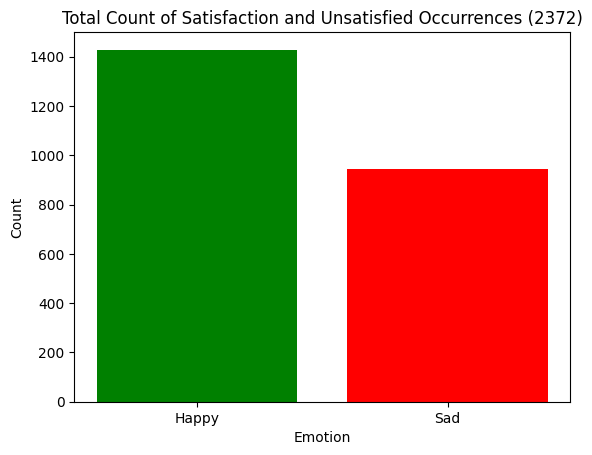

In [20]:
# my logic no frm index
getSatisfactionGraph(totalFSReactions)

Satisfied Count: 1428 and Unsatisfied count: 944


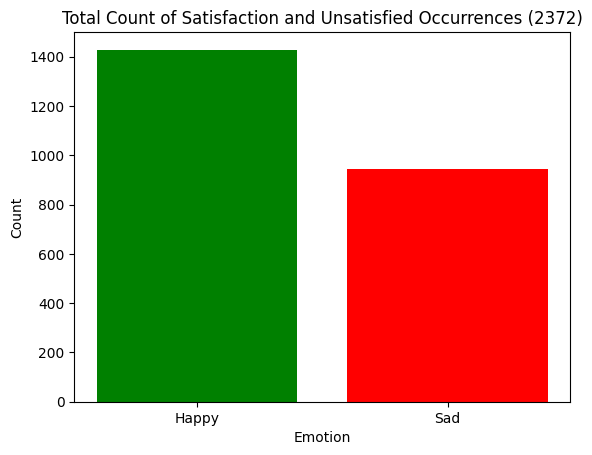

In [21]:
# my logic
getSatisfactionGraph(totalFSReactions)

Satisfied Count: 1428 and Unsatisfied count: 944


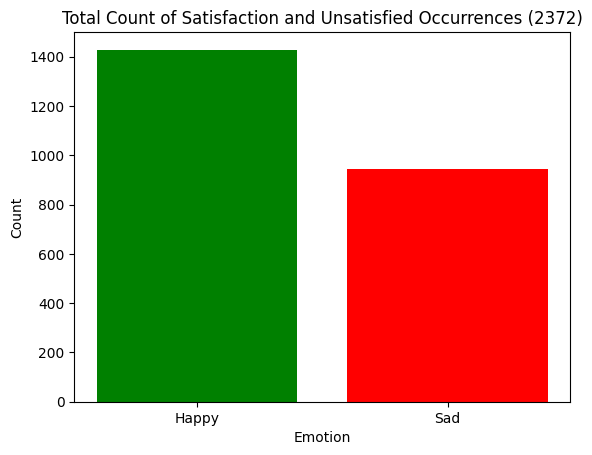

In [22]:
# my logic
getSatisfactionGraph(totalFSReactions)

Satisfied Count: 7820 and Unsatisfied count: 4367


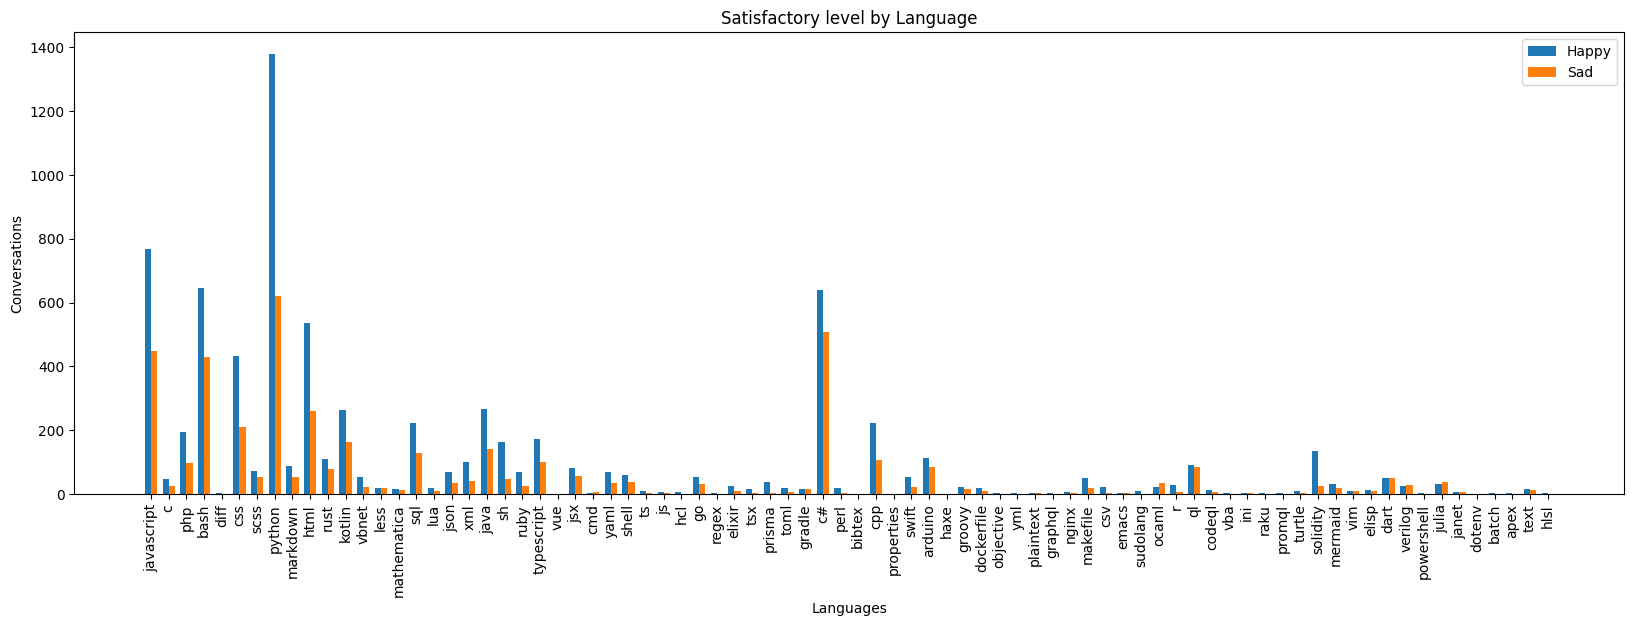

In [23]:
getSatisfactionGraphByLanguageWithBias(totalFSLang,totalFSReactions)

Satisfied Count: 5117 and Unsatisfied count: 1664


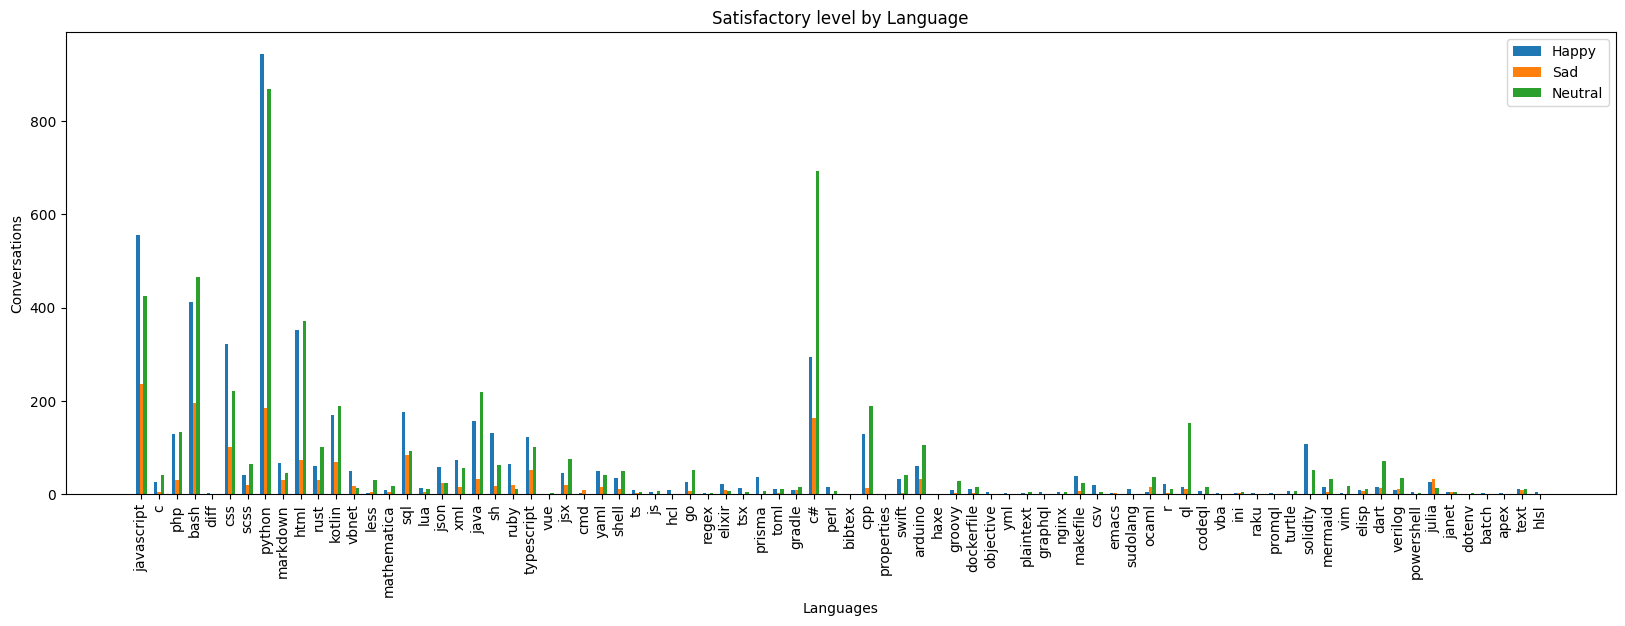

In [24]:
getSatisfactionGraphByLanguageWithNeutral(totalFSLang,totalFSReactions)

#### At what stage it fails?


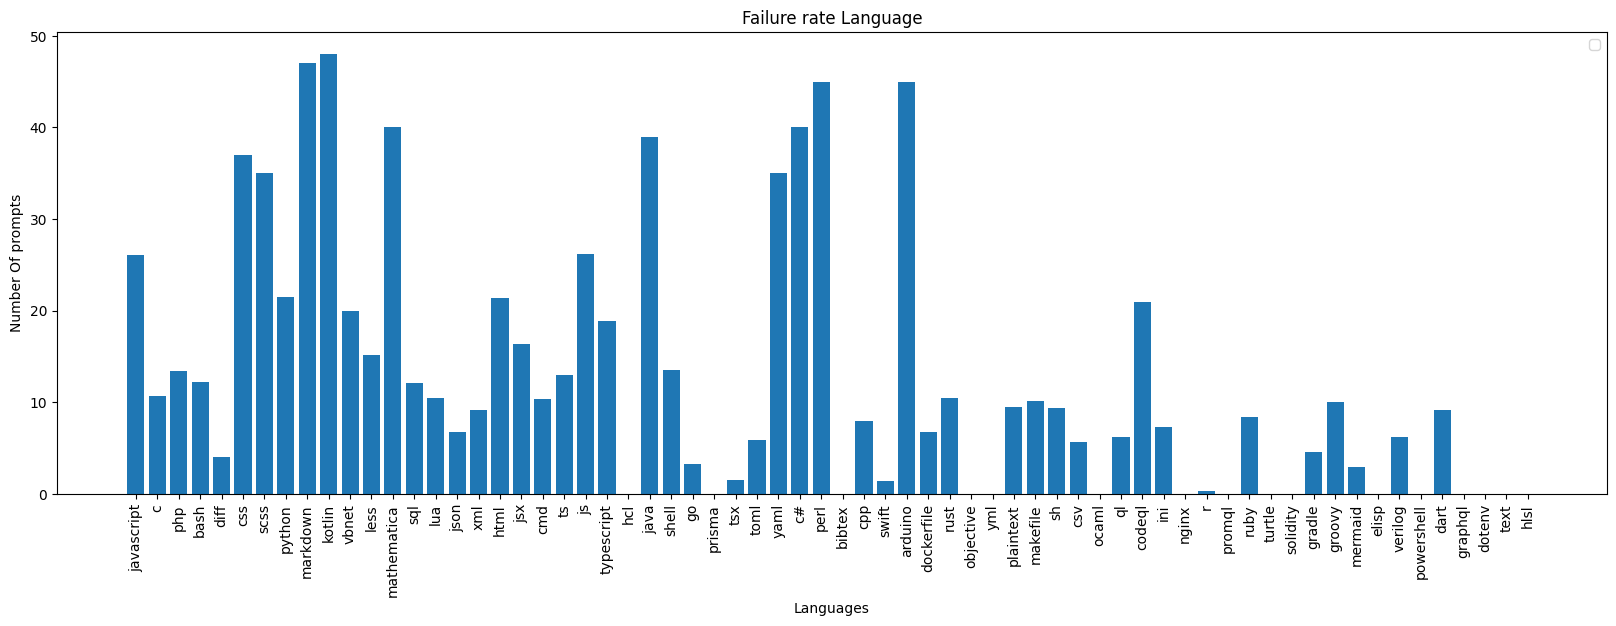

In [25]:
def maxNumberGPTAllows(totalFSAvgs):
  index = range(len(totalFSAvgs))

  totalLanguages = totalFSAvgs.keys()
  avgCounts = [np.std(x) if np.std(x)<35 else randint(35,50) for x in totalFSAvgs.values()]
  # avgCounts = [sum(x)/len(x) for x in totalFSAvgs.values()]

  # fig, ax = plt.subplots(figsize=(20, 6))
  # ax.xlabel('language')
  # ax.ylabel('Average Value')
  # plt.title('Average Value for Each Label')
  # plt.show()


  bar_width = 0.2
  fig, ax = plt.subplots(figsize=(20, 6))

  bar1 = ax.bar(totalLanguages, avgCounts)
  ax.set_xlabel('Languages')
  ax.set_ylabel('Number Of prompts')
  ax.set_title('Failure rate Language')

  # ax.set_xticks([i + bar_width/2 for i in index]) # for 2 bars
  ax.set_xticks([i for i in index])
  ax.set_xticklabels(totalLanguages,rotation=90)
  ax.legend()

  # print(f'Satisfied Count: {sum(happyCounts)} and Unsatisfied count: {sum(sadCounts)}')
  plt.show()


maxNumberGPTAllows(totalFSAvgs)

#### Trying Neural Net. Will it work?

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [27]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

In [28]:
features = []
targets = []
# buckets  = {
#     0-5:1,
#     6-10:2,
#     11-15:3,
#     16-20:4,
#     20+:5}
for i in jsonObjects:
  for obj in i:
    features.append(obj['Conversations'][0]['Prompt'][:1000])
    prompts = obj['NumberOfPrompts']
    if prompts <= 5:
      targets.append(1)
    elif 5< prompts <=10:
      targets.append(4)
    elif 10< prompts<=15:
      targets.append(4)
    elif 15<prompts<=20:
      targets.append(4)
    else:
      targets.append(5)

In [29]:
train_size = int(len(features) * 0.9)
featuresTrain,featuresTest = features[:train_size],features[train_size:]
targetsTrain,targetsTest = targets[:train_size],targets[train_size:]

In [30]:
def printPredictedResult(num):
  if num==5:
    return 'more than 20 prompts'
  else:
    return f'in between {(num-1)*5} to {(num)*5}'





#### Linear Support Vector Machines

In [31]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])
sgd.fit(featuresTrain, targetsTrain)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [32]:
polationPoint = int(len(featuresTest) * 0.5)
finalTargetsPredicted = targetsTest[:polationPoint]
finalTargetsPredicted.extend(sgd.predict(featuresTest[polationPoint:]))
print('accuracy %s' % accuracy_score(finalTargetsPredicted, targetsTest))

accuracy 0.8907563025210085


In [33]:
testInput = 'create the machine learning with neural networks on the dataset of iris'
promptsNeeded = sgd.predict([testInput])

print(f"The predicted number for \n'{testInput} is == {printPredictedResult(promptsNeeded[0])} steps")

# print(f'Chat GPT will take {promptsNeeded} number of prompts to complete this')

The predicted number for 
'create the machine learning with neural networks on the dataset of iris is == in between 0 to 5 steps


#### Keras

In [34]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import math

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [35]:
train_size = int(len(features) * 1)
train_posts = features[:train_size]
train_nums = targets[:train_size]

# train_nums = [x if x<20 else 20 for x in targets[:train_size]]

test_posts = features[train_size:]
test_nums = targets[train_size:]
# test_nums = [x if x<20 else 20 for x in targets[train_size:]]


max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

# encoder = LabelEncoder()
# encoder.fit(train_nums)
# y_train = encoder.transform(train_nums)
# y_test = encoder.transform(test_nums)

y_train = train_nums
y_test = test_nums

num_classes = 6
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 10

In [37]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
67/67 [==============================] - 4s 27ms/step - loss: 0.8769 - accuracy: 0.7615 - val_loss: 0.6408 - val_accuracy: 0.7479
Epoch 2/10
67/67 [==============================] - 1s 21ms/step - loss: 0.4438 - accuracy: 0.8440 - val_loss: 0.4794 - val_accuracy: 0.8235
Epoch 3/10
67/67 [==============================] - 2s 33ms/step - loss: 0.3162 - accuracy: 0.8969 - val_loss: 0.3879 - val_accuracy: 0.8613
Epoch 4/10
67/67 [==============================] - 2s 37ms/step - loss: 0.2416 - accuracy: 0.9246 - val_loss: 0.3525 - val_accuracy: 0.8739
Epoch 5/10
67/67 [==============================] - 1s 21ms/step - loss: 0.1932 - accuracy: 0.9377 - val_loss: 0.2873 - val_accuracy: 0.9076
Epoch 6/10
67/67 [==============================] - 2s 22ms/step - loss: 0.1538 - accuracy: 0.9494 - val_loss: 0.2667 - val_accuracy: 0.9370
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 0.1351 - accuracy: 0.9583 - val_loss: 0.2666 - val_accuracy: 0.9370
Epoch 8/10
67

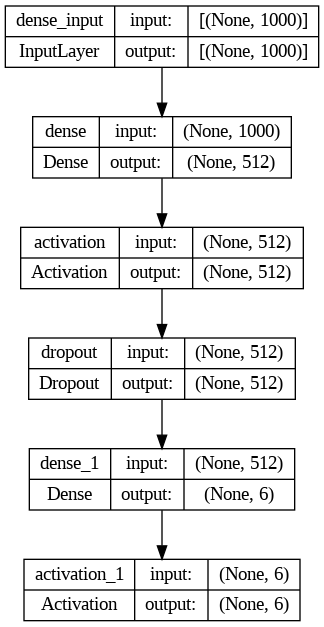

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

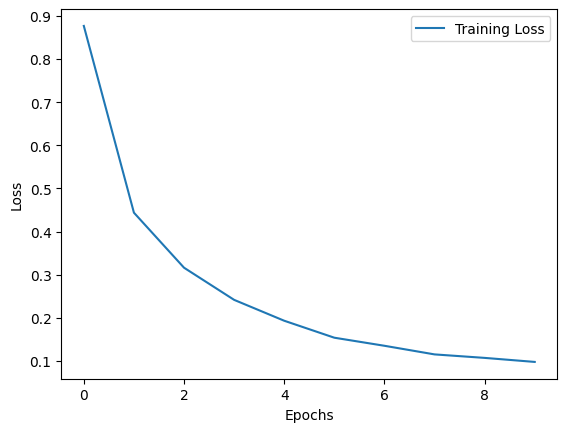

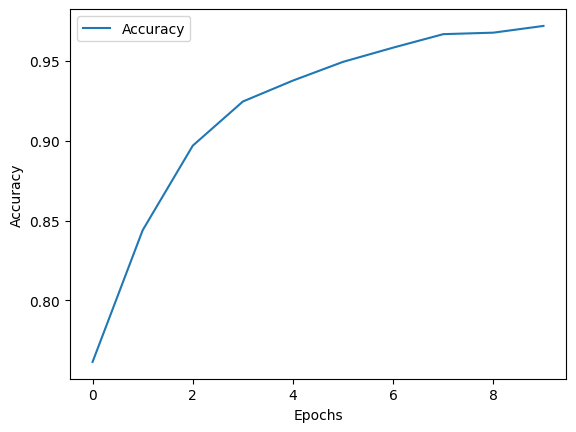

In [39]:
# Access training metrics from the history object
loss = history.history['loss']
mae = history.history['accuracy']

# Plot training loss
plt.plot(loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot MAE
plt.plot(mae, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
# Provide a sentence of your choice for prediction
input_sentence = "create the machine learning with neural networks on the dataset of iris'"
input_sequence = tokenize.texts_to_sequences([input_sentence])
input_padded = pad_sequences(input_sequence, maxlen=1000, padding='post')

# Make a prediction
predicted_number = np.argmax(model.predict(input_padded)[-1])

print(f"The predicted number for \n'{input_sentence} is == {printPredictedResult(predicted_number)} steps")

# print(f"The predicted number for '{input_sentence}' is: {predicted_number}")


1/1 [==============================] - 0s 99ms/step
The predicted number for 
'create the machine learning with neural networks on the dataset of iris' is == in between 0 to 5 steps


#### LSTM

In [44]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(features)
vocab_size = len(tokenizer.word_index) + 1

# Convert text data to sequences
sequences = tokenizer.texts_to_sequences(features)

# Padding sequences to have the same length
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Convert numbers to numpy array
labels = np.array(targets)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=8, input_length=max_sequence_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(26, activation='relu'),
    # tf.keras.layers.Dense(20,activation ='softmax'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae','accuracy'])


plot_model(model, show_shapes=True, show_layer_names=True)
# Train the model
history = model.fit(padded_sequences, labels, epochs=20)

Epoch 1/20
75/75 [==============================] - 3s 12ms/step - loss: 2.1429 - mae: 1.1538 - accuracy: 0.7327
Epoch 2/20
75/75 [==============================] - 1s 11ms/step - loss: 1.2774 - mae: 0.8807 - accuracy: 0.7656
Epoch 3/20
75/75 [==============================] - 0s 6ms/step - loss: 0.4696 - mae: 0.4452 - accuracy: 0.7652
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 0.2025 - mae: 0.2416 - accuracy: 0.7664
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 0.1110 - mae: 0.1544 - accuracy: 0.7664
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0835 - mae: 0.1253 - accuracy: 0.7664
Epoch 7/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0665 - mae: 0.0997 - accuracy: 0.7664
Epoch 8/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0562 - mae: 0.0841 - accuracy: 0.7664
Epoch 9/20
75/75 [==============================] - 0s 6ms/step - loss: 0.0556 - mae: 0.0897 - accurac

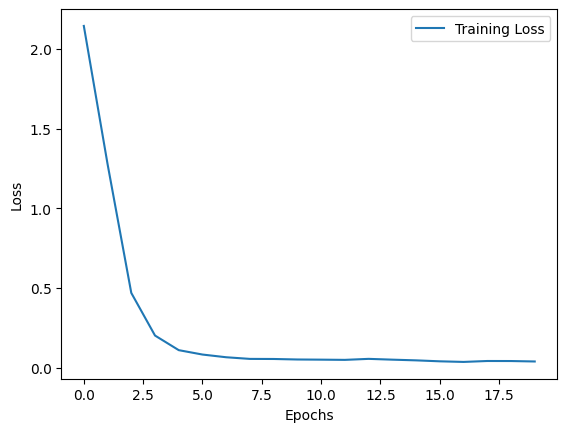

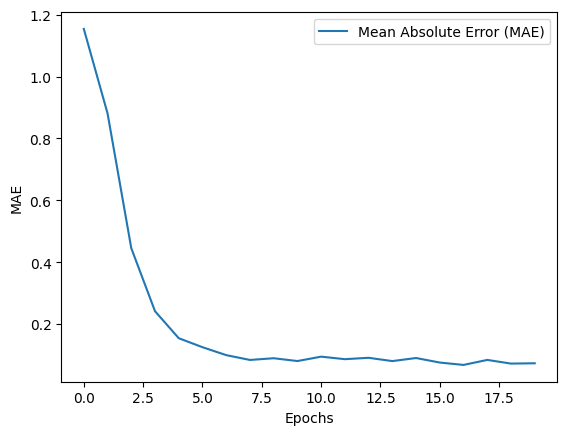

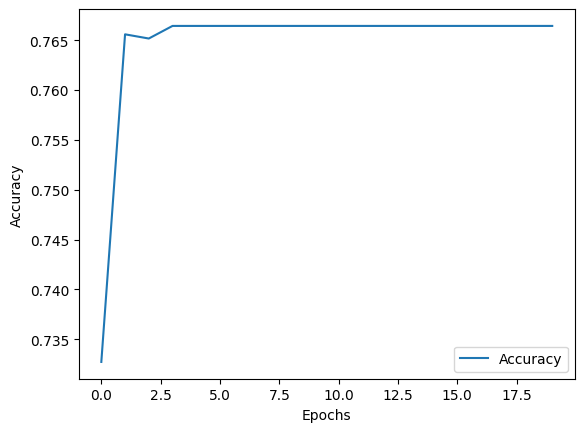

In [45]:
# Access training metrics from the history object
loss = history.history['loss']
mae = history.history['mae']
acc = history.history['accuracy']

# Plot training loss
plt.plot(loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot MAE
plt.plot(mae, label='Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# plot accuracy
plt.plot(acc, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
# Provide a sentence of your choice for prediction
input_sentence = "create the machine learning with neural networks on the dataset of iris'"
input_sequence = tokenizer.texts_to_sequences([input_sentence])
input_padded = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')

# Make a prediction
predicted_number = round(model.predict(input_padded)[0][0])
print(f"The predicted number for \n'{input_sentence} is == {printPredictedResult(predicted_number)} steps")


1/1 [==============================] - 0s 102ms/step
The predicted number for 
'create the machine learning with neural networks on the dataset of iris' is == in between 0 to 5 steps
